# Objective:
### 1) To find out significant variables required for the prediciton of house prices
### 2) Build a model using the variables

In [147]:
# Importing the libraries
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings("ignore")

In [148]:
# Reading and viewing the data
data = pd.read_csv("train.csv")
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [149]:
# Total number of columns are 81
# Checking the value counts in the dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [150]:
#  Form the data dictionary, the column id is irrelevant for prediction
data.drop("Id",inplace=True,axis=1)

In [151]:
# Some of the columns have many missing values which will not help in building the model
# Deleting the columns havving more than 30% of missing values
remo_col=[]
for col in data.columns:
    if data[col].isna().sum() > 0.7* len(data):
        data.drop(col,inplace=True,axis=1)
        remo_col.append(col)
print("The number of columns removed are: ",len(remo_col))
print(remo_col)

The number of columns removed are:  4
['Alley', 'PoolQC', 'Fence', 'MiscFeature']


In [152]:
# Sorting the data based on data type
cat_data=data.loc[:,(data.dtypes == object).values]
num_data= data.loc[:,~(data.dtypes == object).values]


In [153]:
# Removing columns having a single value occuring more than 90% of times
single_rep_col = []
for col in cat_data:
    if (cat_data[col].value_counts(normalize=True).values)[0]>=0.9:
        single_rep_col.append(col)
        data.drop(col,inplace=True,axis=1)
print("The number of columns removed are: ",len(single_rep_col))
print(single_rep_col)

The number of columns removed are:  13
['Street', 'Utilities', 'LandSlope', 'Condition2', 'RoofMatl', 'BsmtCond', 'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageQual', 'GarageCond', 'PavedDrive']


In [154]:
# Checking columns having missing values in data
mis_col=[]
for col in data.columns:
    if not(data[col].isna().sum() == 0):
        mis_col.append(col)
print("The number of columns having missing columns: ",len(mis_col))
print(mis_col)


The number of columns having missing columns:  11
['LotFrontage', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish']


In [155]:
#  Misssing value imputation
#  Filling the missing values with median if the column is numeric and with mode if the column is categorical
for miscol in mis_col:
    if miscol in num_data.columns:
        data[miscol].fillna(data[miscol].median(),inplace=True)
    elif miscol in cat_data.columns:
        data[miscol].fillna(data[miscol].value_counts().values[0],inplace=True)


In [156]:
#  Checking the df after missing value imputation
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 63 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1460 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   LotShape       1460 non-null   object 
 5   LandContour    1460 non-null   object 
 6   LotConfig      1460 non-null   object 
 7   Neighborhood   1460 non-null   object 
 8   Condition1     1460 non-null   object 
 9   BldgType       1460 non-null   object 
 10  HouseStyle     1460 non-null   object 
 11  OverallQual    1460 non-null   int64  
 12  OverallCond    1460 non-null   int64  
 13  YearBuilt      1460 non-null   int64  
 14  YearRemodAdd   1460 non-null   int64  
 15  RoofStyle      1460 non-null   object 
 16  Exterior1st    1460 non-null   object 
 17  Exterior2nd    1460 non-null   object 
 18  MasVnrTy

In [157]:
#  Dummy encoding for categorical variables
data_with_dummies = pd.get_dummies(data,drop_first=True)

<AxesSubplot:>

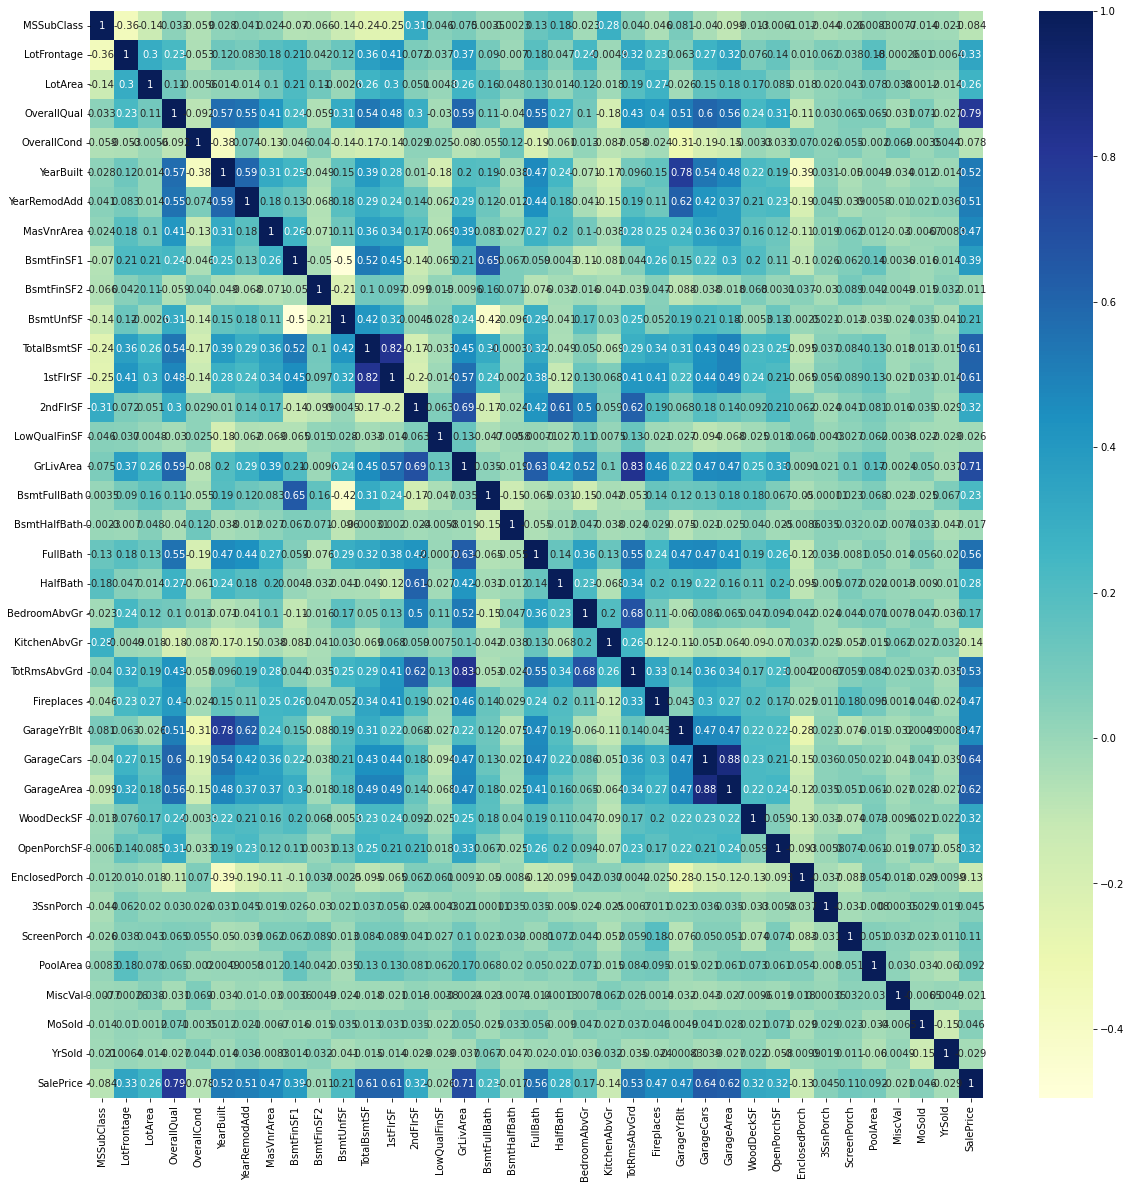

In [158]:
# Plotting corelation matrix between variables
corr_mat = data.corr()
corr_mat_with_dummies = data_with_dummies.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr_mat,annot=True,cmap="YlGnBu")

In [159]:
#  Listing the top corelated variables
corr_mat_with_dummies.sort_values(by="SalePrice")["SalePrice"].head()

ExterQual_TA       -0.589044
KitchenQual_TA     -0.519298
BsmtQual_TA        -0.452394
GarageFinish_Unf   -0.410608
MasVnrType_None    -0.374468
Name: SalePrice, dtype: float64

In [160]:
corr_mat_with_dummies.sort_values(by="SalePrice",ascending=False)["SalePrice"].head(6)

SalePrice      1.000000
OverallQual    0.790982
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
TotalBsmtSF    0.613581
Name: SalePrice, dtype: float64

In [161]:
#  From the heatmap it can be seen that from the list of features the top corelated variables with SalePrice are
#  1) OverallQual
#  2) GrLivArea
#  3) GarageCars
#  4) GarageArea
#  5) TotalBsmtSF
#  6) ExterQual_TA - ExterQual
#  7) KitchenQual_TA - KitachenQual
#  8) BsmtQual_TA -  BsmtQual
#  9) GarageFinish_Unf - GarageFinish
#  10) MasVnrType_None - MasVnrType

In [162]:
data = data_with_dummies

In [163]:
#  Model build
#  1) Splitting the data
X = list(data.columns)
X.remove("SalePrice")
y = ["SalePrice"]
X_train, X_test, y_train, y_test = train_test_split(data[X], data[y], test_size=0.3, random_state=42)


In [164]:
#  2) Scaling the data
mms = MinMaxScaler()
X_train = pd.DataFrame(mms.fit_transform(X_train),columns=X_train.columns)

In [165]:
#  3) Using RFE for selecting top 50 features
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
model = LinearRegression()
rfe_obj = RFE(model,50)
rfe_obj.fit(X_train,y_train)

RFE(estimator=LinearRegression(), n_features_to_select=50)

In [166]:
#  Getting the top 50 features
X_train = X_train.loc[:,rfe_obj.get_support()]

In [167]:
#  Training lasso and ridge regression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
lasso = Lasso()
ridge = Ridge()
lasso_grid = {"alpha":[1,10,50,100]}
ridge_grid = {"alpha":[1,10,50,100]}
grid_lasso = GridSearchCV(lasso,param_grid=lasso_grid,scoring="r2",cv=5)
grid_ridge = GridSearchCV(ridge,param_grid=ridge_grid,scoring="r2",cv=5)
grid_lasso.fit(X_train,y_train)
grid_ridge.fit(X_train,y_train)


GridSearchCV(cv=5, estimator=Ridge(), param_grid={'alpha': [1, 10, 50, 100]},
             scoring='r2')

In [168]:
X_test = pd.DataFrame(mms.transform(X_test),columns=X_test.columns)
X_test=X_test.loc[:,rfe_obj.get_support()]


In [170]:
from sklearn.metrics import r2_score
print(r2_score(grid_lasso.predict(X_test),y_test))

0.7936953924980967


In [94]:
grid_ridge.best_score_

0.7827103241705243

In [69]:
coeff=grid_lasso.best_estimator_.coef_
coeff=coeff[coeff!=0]